In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import datetime as dt


Per prima cosa ci occupiamo di effettuare previsioni sui prezzi dell'oro utilizzando un modello ARIMA.

In [47]:
#df = pd.read_csv('GLD.csv', parse_dates = True, index_col = 0)

In [48]:
start = '2004-5-31'

In [49]:
df = yf.download('GC=F', start) # prendiamo 20 anni di prezzi dell'oro

[*********************100%%**********************]  1 of 1 completed


In [50]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-28,2336.899902,2359.699951,2336.899902,2355.199951,2355.199951,26
2024-05-29,2340.300049,2340.300049,2340.300049,2340.300049,2340.300049,119317
2024-05-30,2336.899902,2349.500000,2320.800049,2342.899902,2342.899902,32587
2024-05-31,2344.100098,2354.000000,2319.000000,2322.899902,2322.899902,32587
2024-06-03,2348.000000,2351.399902,2334.800049,2346.500000,2346.500000,52237


In [51]:
df.to_csv('gold.csv')

In [52]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-06-01,393.899994,399.0,393.299988,394.600006,394.600006,1864
2004-06-02,394.500000,397.5,390.000000,390.700012,390.700012,937
2004-06-03,390.700012,393.0,387.399994,388.100006,388.100006,601
2004-06-04,388.399994,391.5,385.500000,390.899994,390.899994,234
2004-06-07,392.600006,394.0,392.000000,393.799988,393.799988,130


In [53]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-28,2336.899902,2359.699951,2336.899902,2355.199951,2355.199951,26
2024-05-29,2340.300049,2340.300049,2340.300049,2340.300049,2340.300049,119317
2024-05-30,2336.899902,2349.500000,2320.800049,2342.899902,2342.899902,32587
2024-05-31,2344.100098,2354.000000,2319.000000,2322.899902,2322.899902,32587
2024-06-03,2348.000000,2351.399902,2334.800049,2346.500000,2346.500000,52237


In [54]:
df_settle = df['Adj Close'].resample('ME').last()

In [55]:
df_settle

Date
2004-06-30     392.600006
2004-07-31     391.000000
2004-08-31     410.399994
2004-09-30     418.700012
2004-10-31     428.500000
                 ...     
2024-02-29    2045.699951
2024-03-31    2217.399902
2024-04-30    2291.399902
2024-05-31    2322.899902
2024-06-30    2346.500000
Freq: ME, Name: Adj Close, Length: 241, dtype: float64

In [56]:
df_rolling = df_settle.rolling(12) 
df_mean = df_rolling.mean() # media mobile semplice a 12 mesi
df_std = df_rolling.std() # volatilità a 12 mesi

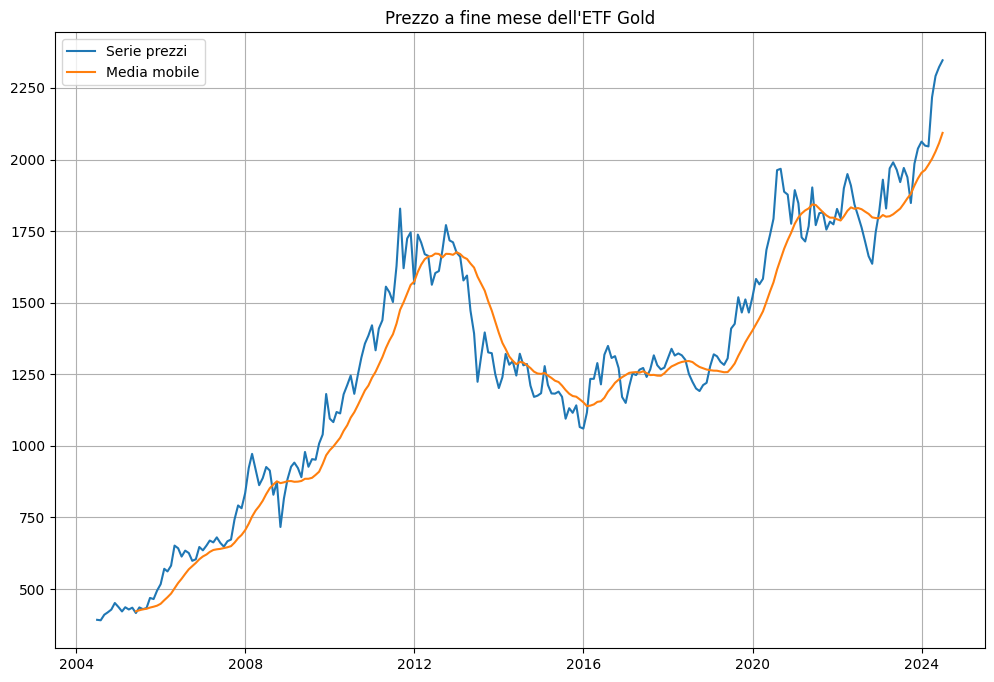

In [57]:
plt.figure(figsize=(12,8))
plt.plot(df_settle, label = 'Serie prezzi')
plt.plot(df_mean, label = 'Media mobile')
plt.legend()
plt.title("Prezzo a fine mese dell'ETF Gold")
plt.grid()
plt.show()

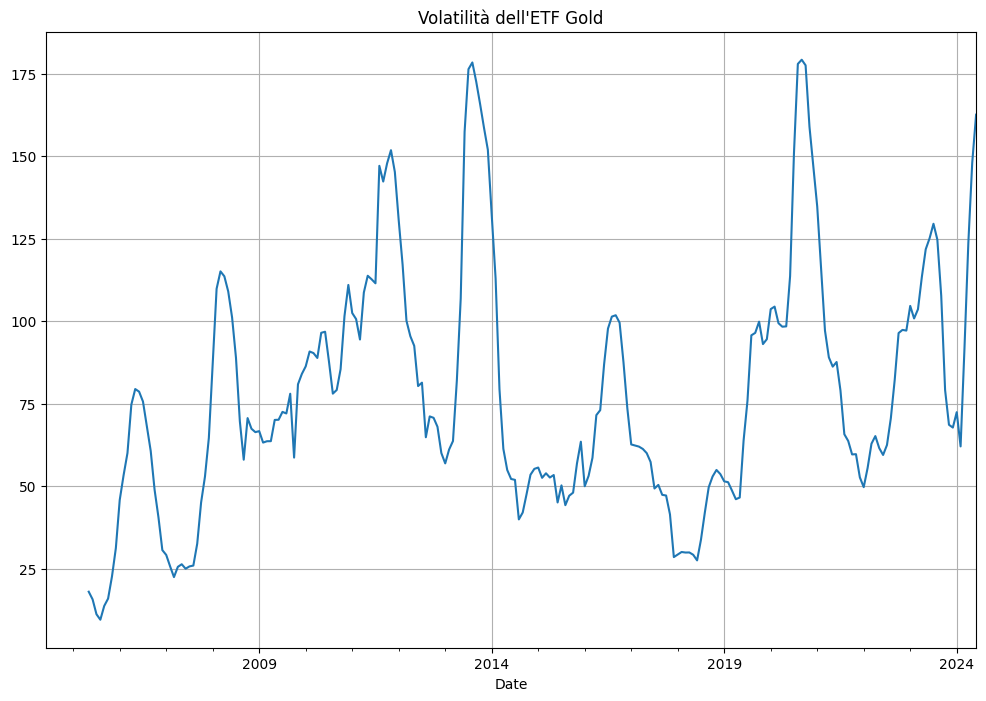

In [58]:
df_std.plot(figsize=(12,8))
plt.title("Volatilità del prezzo dell'ETF Gold")
plt.grid();

#### Verifica stazionarietà

In [59]:
from statsmodels.tsa.stattools import adfuller

In [60]:
result = adfuller(df_settle) # effettua il test Augmented Dickey Fuller sulla serie (per controllarne la stazionarietà)

In [61]:
print('ADF statistic: ', result[0])
print('p-value: ', result[1])

critical_values = result[4]

for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))

ADF statistic:  -0.5428854284429105
p-value:  0.8833725478348244
Critical value (1%): -3.458
Critical value (5%): -2.874
Critical value (10%): -2.573


La serie dei prezzi è assolutamente __non__ stazionaria. <br>
Si può dire che una serie è stazionaria se ADF statistic è più piccolo dei valori critici riportati sotto (non è il caso della serie dei prezzi).

#### Detrending

In [62]:
df_log = np.log(df_settle) # si passa da serie dei prezzi a serie logaritmica dei prezzi

In [63]:
df_log_ma = df_log.rolling(2).mean() # si calcola la media mobile a 2 giorni della serie logaritmica dei prezzi

In [64]:
df_detrend = df_log - df_log_ma # il trend viene rimosso facendo prezzo logaritmico - media dei prezzi logaritmici dei due giorni precedenti
df_detrend.dropna(inplace= True)

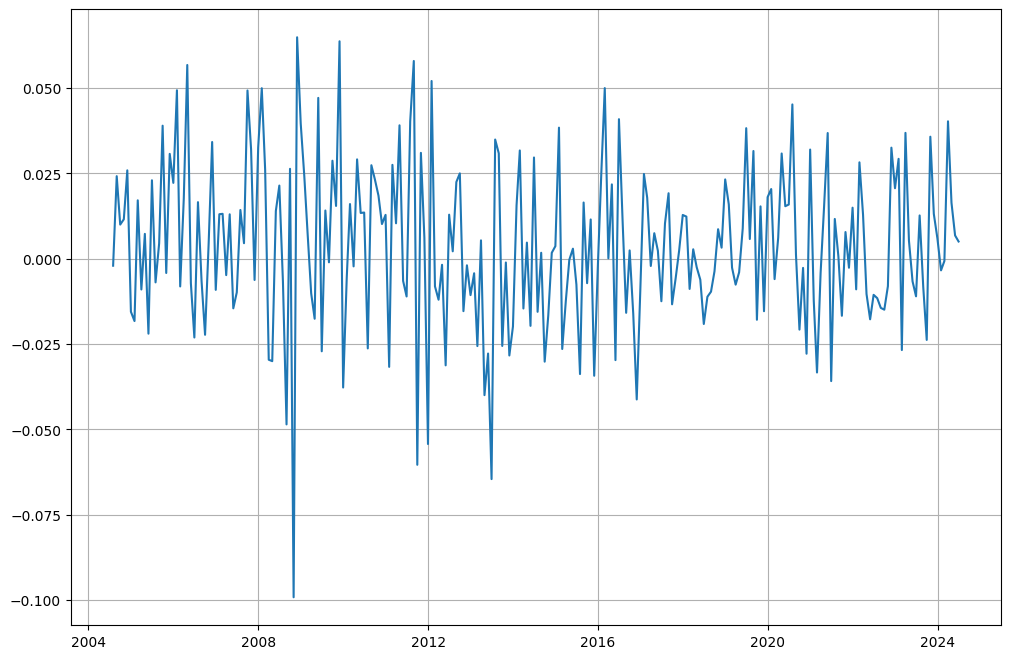

In [65]:
plt.plot(df_detrend)
plt.grid(True)

In [66]:
df_detrend_rolling = df_detrend.rolling(12)
df_detrend_ma = df_detrend_rolling.mean()
df_detrend_std = df_detrend_rolling.std()

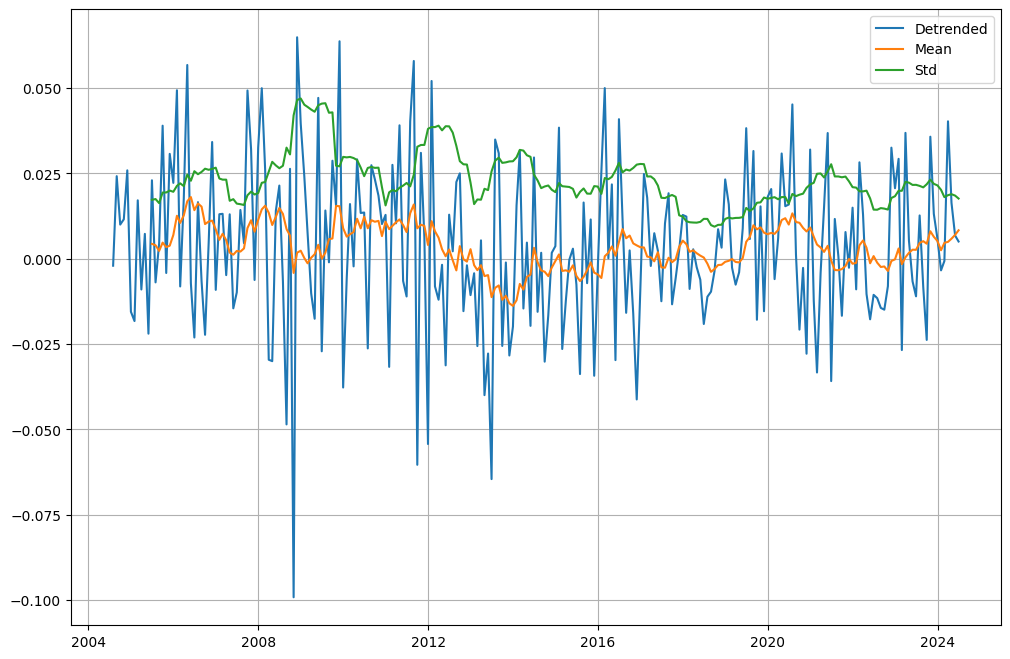

In [67]:
plt.figure(figsize=(12,8))
plt.plot(df_detrend, label = 'Detrended')
plt.plot(df_detrend_ma, label = 'Mean')
plt.plot(df_detrend_std, label = 'Std')
plt.legend(loc='upper right')
plt.grid()
plt.show()


In [68]:
result = adfuller(df_detrend)
print('ADF statistic: ', result[0])
print('p-value: ', round(result[1],5))

critical_values = result[4]

for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))


ADF statistic:  -17.16460370547302
p-value:  0.0
Critical value (1%): -3.458
Critical value (5%): -2.874
Critical value (10%): -2.573


Sulla nuova serie, il test ADF restituisce il valore -17 (che è ampiamente minore dei valori critici): pertanto, la serie può essere considerata stazionaria.

Per ottenere facilmente una serie stazionaria, si può pensare di lavorare con rendimenti logaritmici (invece dei prezzi).

In [69]:
df_log_diff = df_log.diff(1).dropna() # rendimenti logaritmici

df_log_diff_rolling = df_log_diff.rolling(12)
df_diff_ma = df_log_diff_rolling.mean()
df_diff_std = df_log_diff_rolling.std()


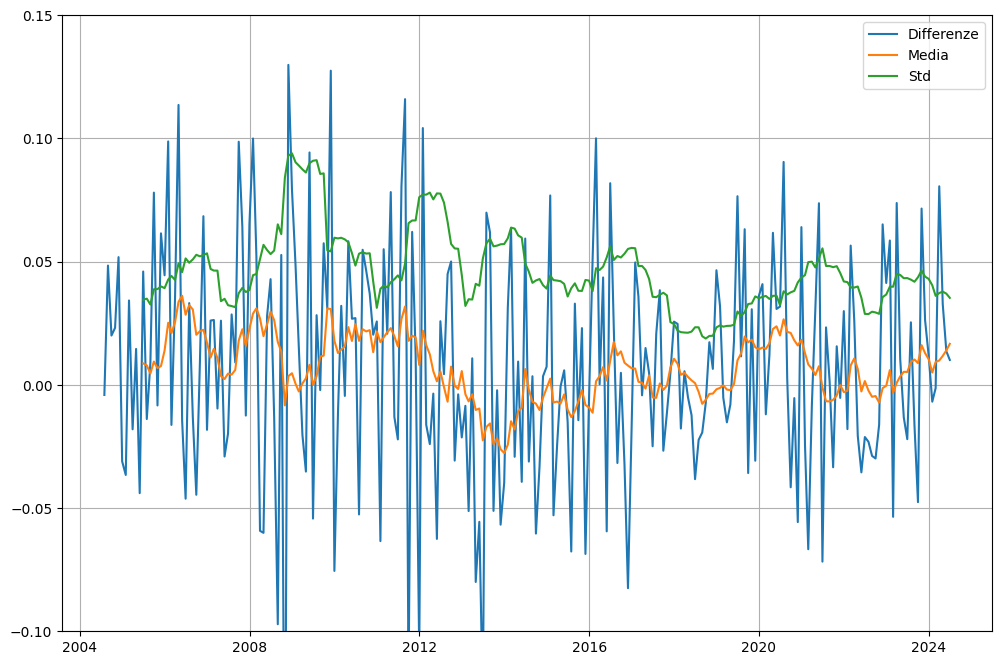

In [70]:
plt.figure(figsize = (12,8))
plt.plot(df_log_diff, label = 'Differenze')
plt.plot(df_diff_ma, label = 'Media')
plt.plot(df_diff_std, label = 'Std')
plt.legend(loc = 'upper right')
plt.ylim((-0.10, 0.15))
plt.grid()
plt.show()

In [71]:
result = adfuller(df_log_diff)
print('ADF statistic: ', result[0])
print('p-value: ', round(result[1], 5))

critical_values = result[4]

for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))



ADF statistic:  -17.16460370547301
p-value:  0.0
Critical value (1%): -3.458
Critical value (5%): -2.874
Critical value (10%): -2.573


Anche in questo caso il test ADF conferma la stazionarietà della serie.

#### Scomposizione

Rimuoviamo trend e stagionalità dalla serie.

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [73]:
decompose_result = seasonal_decompose(df_log.dropna()) #freq=12)

In [74]:
df_trend = decompose_result.trend
df_season = decompose_result.seasonal
df_residual = decompose_result.resid

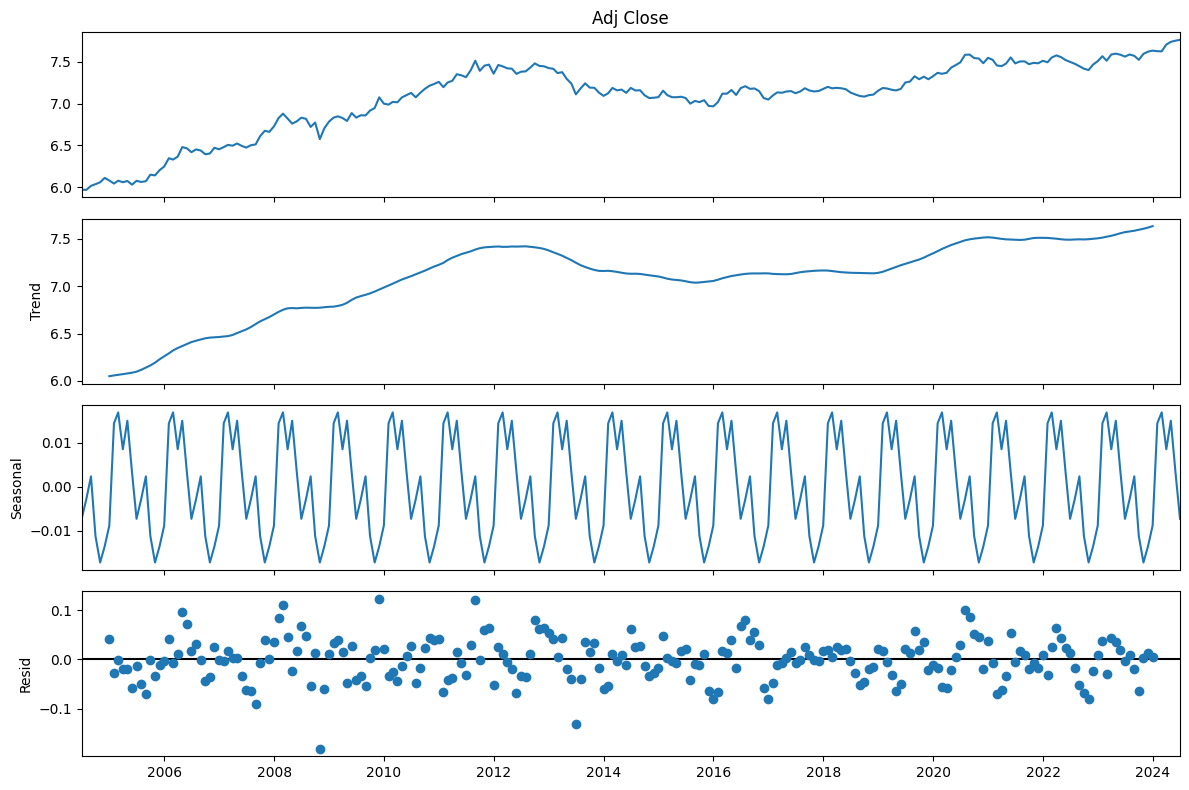

In [75]:
plt.rcParams['figure.figsize'] = (12,8)
fig = decompose_result.plot()

In [76]:
df_log_diff = df_residual.diff().dropna() # differenze dei residui

In [77]:
df_diff_rolling = df_log_diff.rolling(12)
df_diff_ma = df_diff_rolling.mean()
df_diff_std = df_diff_rolling.std()

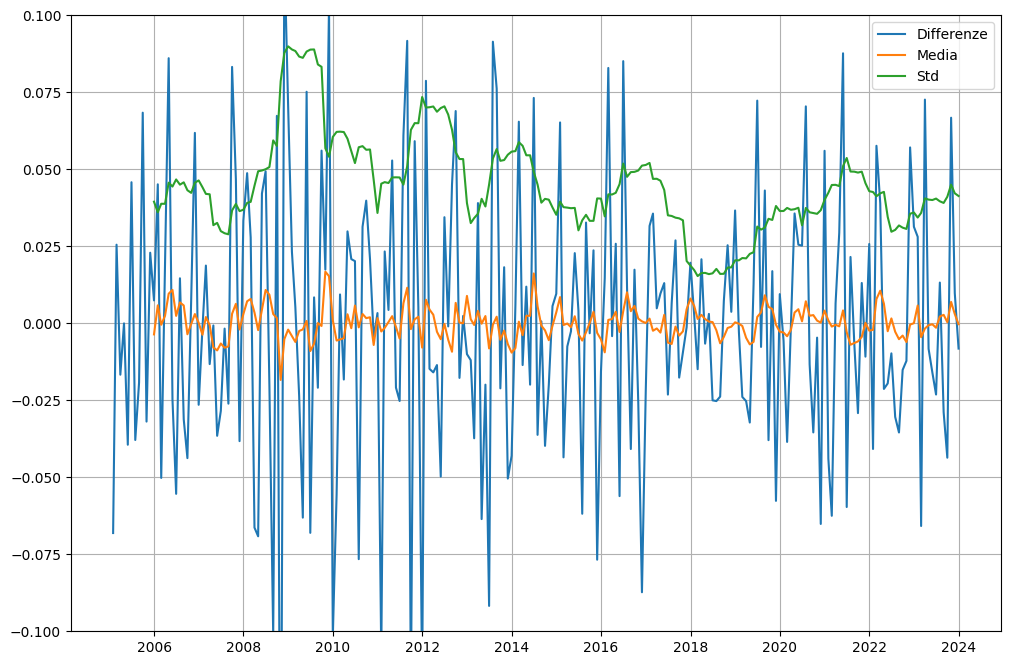

In [78]:
plt.figure(figsize=(12,8))
plt.plot(df_log_diff, label = 'Differenze dei residui')
plt.plot(df_diff_ma, label = 'Media')
plt.plot(df_diff_std, label = 'Std')
plt.grid(True)
plt.ylim((-0.10, 0.10))
plt.legend();

In [79]:
result = adfuller(df_residual.dropna())
print('ADF statistic: ', result[0])
print('p-value: ', round(result[1], 5))

critical_values = result[4]

for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))


ADF statistic:  -6.818512487339739
p-value:  0.0
Critical value (1%): -3.461
Critical value (5%): -2.875
Critical value (10%): -2.574


Il test ADF conferma la stazionarietà della serie dei residui (pertanto si possono fare previsioni con modelli lineari anche su quelli).

#### ARIMA

In [80]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")

In [81]:
def arima_grid_search(dataframe, s):
    p = d = q = range(2)
    param_combinations = list(itertools.product(p, d, q))
    lowest_aic, pdq, pdqs = None, None, None
    total_iterations = 0
    for order in param_combinations:
        for (p, q, d) in param_combinations:
            seasonal_order = (p, q, d, s)
            total_iterations += 1
            try:
                model = SARIMAX(df_settle, order = order,
                               seasonal_order= seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False,
                               disp = False
                               )
                model_result = model.fit(maxiter=200, disp=False)
                
                if not lowest_aic or model_result.aic < lowest_aic:
                    lowest_aic = model_result.aic
                    pdq, pdqs = order, seasonal_order
            
            except Exception as ex:
                continue
                
    return lowest_aic, pdq, pdqs

In [82]:
df_settle

Date
2004-06-30     392.600006
2004-07-31     391.000000
2004-08-31     410.399994
2004-09-30     418.700012
2004-10-31     428.500000
                 ...     
2024-02-29    2045.699951
2024-03-31    2217.399902
2024-04-30    2291.399902
2024-05-31    2322.899902
2024-06-30    2346.500000
Freq: ME, Name: Adj Close, Length: 241, dtype: float64

In [83]:
lowest_aic, order, seasonal_order = arima_grid_search(df_settle, 12)

In [84]:
print('ARIMA {}x{}'.format(order, seasonal_order))
print('Lowest AIC: %.3f'%lowest_aic)

ARIMA (0, 1, 1)x(0, 1, 1, 12)
Lowest AIC: 2419.183


In [85]:
model = SARIMAX(df_settle, order = order,
                               seasonal_order= seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False,
                               disp = False
                               )
model_results = model.fit(maxiter=200, disp=False)
print(model_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Adj Close   No. Observations:                  241
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1206.591
Date:                            Mon, 03 Jun 2024   AIC                           2419.183
Time:                                    11:52:15   BIC                           2429.281
Sample:                                06-30-2004   HQIC                          2423.263
                                     - 06-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1122      0.053     -2.102      0.036      -0.217      -0.008
ma.S.L12      -0.8877      0.066   

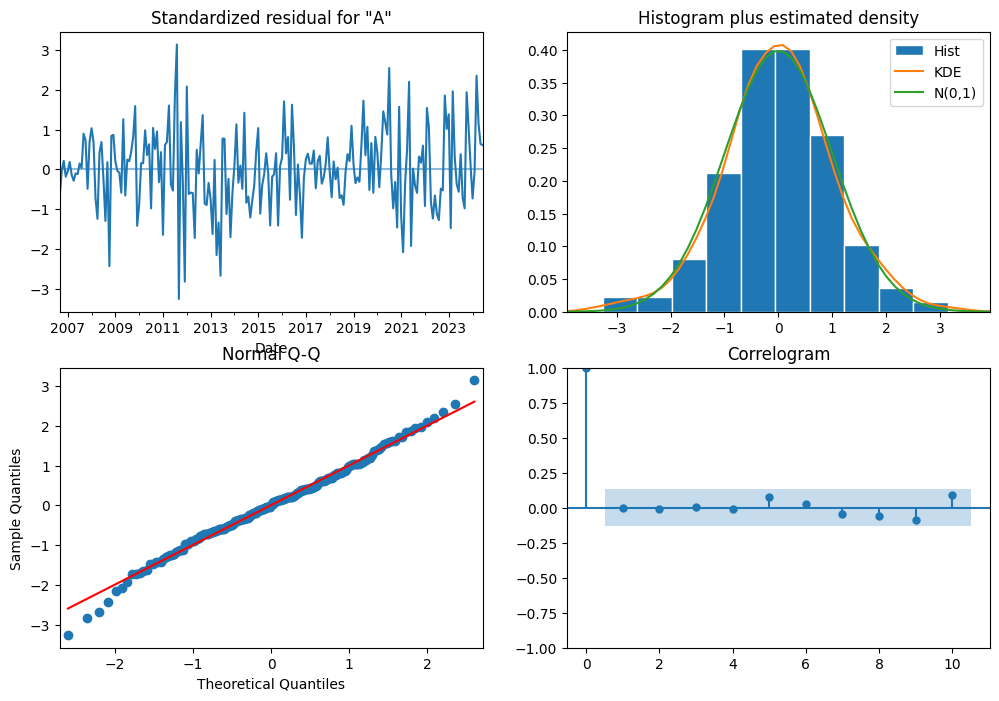

In [86]:
model_results.plot_diagnostics(figsize=(12,8));

In [87]:
model_results.resid.describe()

count    241.000000
mean       1.670515
std       70.900587
min     -242.137921
25%      -39.214750
50%        2.751336
75%       39.389464
max      392.600006
dtype: float64

#### Previsioni con SARIMAX

In [88]:
n = len(df_settle.index)
prediction = model_results.get_prediction(start=n-12*5, end = n+5)
prediction_ci = prediction.conf_int()

In [89]:
print(prediction_ci.head())

            lower Adj Close  upper Adj Close
2019-07-31      1272.404046      1533.029455
2019-08-31      1318.001827      1578.412524
2019-09-30      1369.940100      1630.348109
2019-10-31      1337.432809      1597.840784
2019-11-30      1374.610738      1635.018712


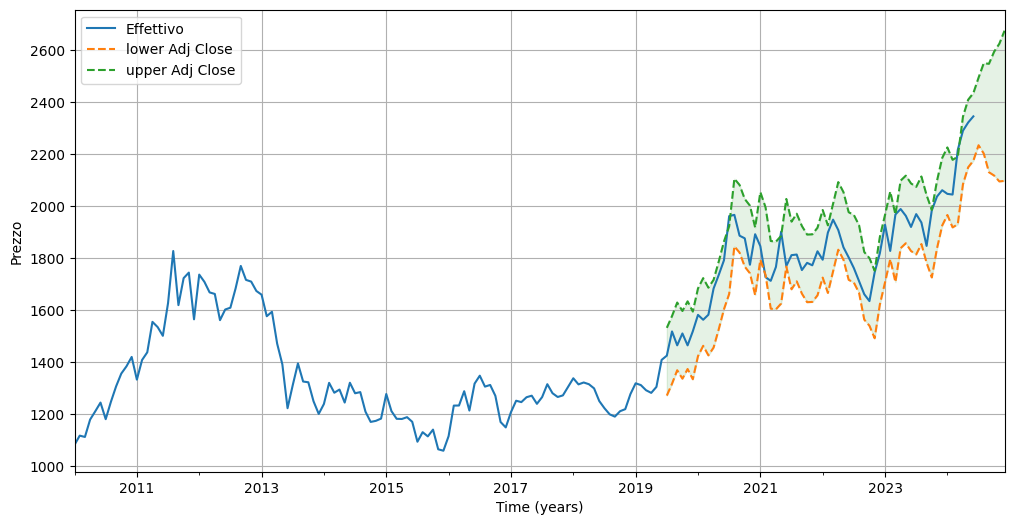

In [90]:
plt.figure(figsize=(12,6))
ax = df_settle['2010':].plot(label = 'Effettivo')
prediction_ci.plot(ax=ax, style = ['--', '--'],
                  label = 'predicted/forecasted')
ci_index = prediction_ci.index
lower_ci = prediction_ci.iloc[:,0]
upper_ci = prediction_ci.iloc[:,1]

ax.fill_between(ci_index, lower_ci, upper_ci, color = 'g', alpha = 0.1)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Prezzo')
plt.grid()
plt.legend()
plt.show()